In [100]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import random
import pandas as pd
import yaml

from argparse import Namespace

import numpy as np
import networkx as nx
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

root_dir = os.path.dirname(
        os.path.dirname(os.path.realpath(".")))

sys.path.append(root_dir)


import logging

from rl_envs_forge.envs.grid_world.grid_world import GridWorld
from common.src.distribution_src import ( 
                                         make_env, 
                                        randomize_walls_positions, 
                                        generate_train_test_split_with_valid_path,
                                        run_distribution_correction_experiment
                                        )
from common.src.simple_dqn_agent import AgentDQN

from common.src.experiment_utils import (
    setup_logger,
    convert_from_string,
    namespace_to_dict,
)

from argparse import Namespace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[(2, 0), (1, 2)]


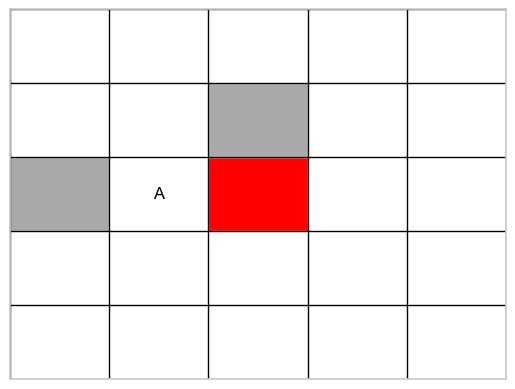

In [101]:
terminal_states = {(2, 2): 1}
start_state = (2, 1)
rows = 5
cols = 5
seed = 2

# random_walls = randomize_walls_positions(rows, cols, start_state, terminal_states, 0.2, seed=seed)
random_walls = [(2, 0), (1, 2)]
print(random_walls)
env = make_env(
    rows,
    cols,
    start_state=start_state,
    p_success=1,
    terminal_states=terminal_states,
    seed=seed,
    walls=random_walls,
)
env.render()

In [102]:
def get_observation_space_shape(observation_space):
    """ Extract a shape-like tuple from a tuple of discrete spaces. """
    return tuple(space.n for space in observation_space.spaces)

In [103]:
env.observation_space

Tuple(Discrete(5), Discrete(5))

In [104]:
env.state

(2, 1)

In [105]:
def state_to_matrix(state, env):
    import numpy as np

    # Extract the environment size from walls and terminal states
    max_rows = env.rows
    max_cols = env.cols
    
    # Create the matrix
    matrix = np.zeros((max_rows, max_cols), dtype=int)
    
    # Mark walls in the matrix
    for wall in env.walls:
        matrix[wall[0], wall[1]] = 1  # Use 1 to indicate walls
    
    # Mark terminal states in the matrix
    for terminal, value in env.terminal_states.items():
        matrix[terminal[0], terminal[1]] = 2 
    
    pos = state
    matrix[pos[0], pos[1]] = 3  # Use 3 to indicate the agent's position
    
    return matrix

state_to_matrix(env.state, env)

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 3, 2, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [106]:
state_shape = get_observation_space_shape(env.observation_space)
state_shape

(5, 5)

In [107]:
# env.mdp

In [108]:
# ts = next(iter(terminal_states))

# for trial in range(100000):
#     random_walls = randomize_walls_positions(rows, cols, start_state, terminal_states, 0.2, seed=trial)

#     if (start_state in random_walls) or (ts in random_walls):
#         raise ValueError("start state or terminal state in walls")

    

In [109]:
transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

transitions_train, transitions_val = generate_train_test_split_with_valid_path(
        transitions_list=transitions_list,
        start_state=start_state,
        terminal_states=terminal_states,
)
        

In [117]:
### Load up a config

file_path = r'D:\Work\repos\phd-research\experiments\dqn\results\2024May16-230833_configs\0000_num_steps_20000\0\cfg.yaml'

# Open the YAML file and load its content into a dictionary
with open(file_path, 'r') as file:
    data = yaml.safe_load(file)
    
opts = Namespace(**data)

logger = setup_logger(
        opts.full_title
    )

opts.seed = random.randint(0, 2**32 - 1) if opts.seed is None else opts.seed
opts.start_state = convert_from_string(opts.start_state)
opts_dict = namespace_to_dict(opts)
# opts_dict = vars(opts)

opts_dict

{'agent_params': {'agent': 'AgentDQN',
  'args_': {'batch_size': 32,
   'epsilon': {'decay': 250000, 'end': 0.01, 'start': 1.0},
   'gamma': 0.9,
   'loss_fcn': 'mse_loss',
   'replay_start_size': 50,
   'target_model_update_freq': 40,
   'train_step_cnt': 500,
   'training_freq': 4,
   'validation_enabled': True,
   'validation_epsilon': 0.001,
   'validation_step_cnt': 250}},
 'algorithm': 'default',
 'cfg_id': 0,
 'cols': 10,
 'experiment': 'experiment_distributions',
 'experiment_arguments': {'num_steps': 20000},
 'full_title': '2024May16-230833_configs_num_steps=20000',
 'neural_fit_mode': 'max',
 'num_steps': 20000,
 'optim': {'args_': {'eps': 0.0003125, 'lr': 0.1}, 'name': 'Adam'},
 'out_dir': '.\\results\\2024May16-230833_configs\\0000_num_steps_20000\\0',
 'p_success': 1,
 'replay_buffer': {'action_dim': 1, 'max_size': 1000, 'n_step': 0},
 'rows': 10,
 'run_id': 0,
 'seed': 3685735817,
 'start_state': (1, 1),
 'terminal_states': {'(8, 8)': 1.0},
 'title': 'num_steps=20000',
 '

In [118]:
logger.info(f"Starting experiment: {opts_dict['full_title']}")

rows = opts_dict["rows"]
cols = opts_dict["cols"]
start_state = opts_dict["start_state"]
p_success = opts_dict["p_success"]
terminal_states = opts_dict["terminal_states"]
run_id = opts_dict["run_id"]

### Setup environments ###
train_env = make_env(rows, cols, start_state, p_success, terminal_states, run_id)
validation_env = make_env(rows, cols, start_state, p_success, terminal_states, run_id)

### Setup output and loading paths ###

experiment_agent = AgentDQN(
    train_env=train_env,
    validation_env=validation_env,
    experiment_output_folder=opts_dict["out_dir"],
    experiment_name=opts_dict["experiment"],
    resume_training_path=None,
    save_checkpoints=True,
    logger=logger,
    config=opts_dict,
)

experiment_agent.train(1)

2024-05-16 23:17:26,881 - 2024May16-230833_configs_num_steps=20000 - INFO - Starting experiment: 2024May16-230833_configs_num_steps=20000
2024-05-16 23:17:26,881 - 2024May16-230833_configs_num_steps=20000 - INFO - Starting experiment: 2024May16-230833_configs_num_steps=20000
2024-05-16 23:17:26,881 - 2024May16-230833_configs_num_steps=20000 - INFO - Starting experiment: 2024May16-230833_configs_num_steps=20000
2024-05-16 23:17:26,888 - 2024May16-230833_configs_num_steps=20000 - INFO - Loaded configuration settings.
2024-05-16 23:17:26,888 - 2024May16-230833_configs_num_steps=20000 - INFO - Loaded configuration settings.
2024-05-16 23:17:26,888 - 2024May16-230833_configs_num_steps=20000 - INFO - Loaded configuration settings.
2024-05-16 23:17:26,890 - 2024May16-230833_configs_num_steps=20000 - INFO - Initialized newtworks and optimizer.
2024-05-16 23:17:26,890 - 2024May16-230833_configs_num_steps=20000 - INFO - Initialized newtworks and optimizer.
2024-05-16 23:17:26,890 - 2024May16-230

In [112]:
# loss_records, bm_error = run_distribution_correction_experiment(
#         tau=opts.tau,
#         seed=opts.seed,
#         run_id=opts.run_id,
#         rows=opts.rows,
#         cols=opts.cols,
#         start_state=opts.start_state,
#         p_success=opts.p_success,
#         terminal_states=opts.terminal_states,
#         num_steps=opts.num_steps,
#         gamma=opts.gamma,
#         min_samples=opts.min_samples,
#         batch_size=opts.batch_size,
#         train_max_iterations=opts.train_max_iterations,
#         neural_fit_mode=opts.neural_fit_mode,
#         algorithm=opts.algorithm,
#         logger=logger,
#     )

In [113]:
# loss_records